# 1. About Dataset

![](https://images.unsplash.com/photo-1507842217343-583bb7270b66?ixlib=rb-1.2.1&w=1000&q=80)

**The dataset contains information about book title, authors, publisher, user and their ratings.we have to find out what book you should be reading next ( there are very few free content recommendation systems that suggest books last I checked ), what are the details of every book you have read, create a word cloud from the books you want to read - all possible approaches to explore the dataset.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bookcrossing-dataset/Book reviews/BX-Books.csv
/kaggle/input/bookcrossing-dataset/Book reviews/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Book reviews/BX-Users.csv
/kaggle/input/goodbooks-10k/to_read.csv
/kaggle/input/goodbooks-10k/ratings.csv
/kaggle/input/goodbooks-10k/book_tags.csv
/kaggle/input/goodbooks-10k/tags.csv
/kaggle/input/goodbooks-10k/sample_book.xml
/kaggle/input/goodbooks-10k/books.csv


**1.1 import Libraries**

In [2]:
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import plotly_express as px
%matplotlib inline

In [3]:
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

**1.2 Read CSV Data**

In [4]:
# goodreads data

books_data = pd.read_csv('/kaggle/input/goodbooks-10k/books.csv',error_bad_lines = False)
tags_data = pd.read_csv('/kaggle/input/goodbooks-10k/book_tags.csv')
ratings_data = pd.read_csv('/kaggle/input/goodbooks-10k/ratings.csv')
book_tags = pd.read_csv('/kaggle/input/goodbooks-10k/tags.csv')

# book crossing data

user_cols = ['user_id', 'location', 'age']
cross_users_data = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX-Users.csv', sep=';', names=user_cols, encoding='latin-1', low_memory=False, skiprows=1)
book_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
cross_books_data = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX-Books.csv', sep=';', names=book_cols, encoding='latin-1', low_memory=False, skiprows=1)
rating_cols = ['user_id', 'isbn', 'rating']
cross_ratings_data = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX-Book-Ratings.csv', sep=';', names=rating_cols, encoding='latin-1', low_memory=False, skiprows=1)

In [5]:
books_data.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
cross_books_data.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
books_data = books_data.drop(columns=['id', 'best_book_id', 'work_id', 'isbn', 'isbn13', 'title','work_ratings_count',
                                   'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 
                                    'image_url','small_image_url'])

1.3 **drop unnecessary data**

In [8]:
books_data = books_data.dropna()
cross_books_data = cross_books_data.drop(columns=['img_s', 'img_m', 'img_l'])

**1.4 Drop Duplicates from all the dataset**

In [9]:
ratings_data = ratings_data.sort_values("user_id")
ratings_data.drop_duplicates(subset =["user_id","book_id"], keep = False, inplace = True) 
books_data.drop_duplicates(subset='original_title',keep=False,inplace=True)
book_tags.drop_duplicates(subset='tag_id',keep=False,inplace=True)
tags_data.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
cross_ratings_data.drop_duplicates(subset =["user_id","isbn"], keep = False, inplace = True) 
cross_books_data.drop_duplicates(subset='book_title',keep=False,inplace=True)

**1.5 clean the text**

In [10]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
cross_books_data['book_title'] = cross_books_data['book_title'].apply(lambda x:clean_text(x))

In [12]:
merge_data = pd.merge(cross_books_data, cross_ratings_data, on='isbn')
merge_data =  merge_data.sort_values('isbn', ascending=True)
merge_data.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating
626418,0000913154,the way things work an illustrated encyclopedi...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8
587195,0001010565,mogs christmas,Judith Kerr,1992,Collins,209516,0
587194,0001010565,mogs christmas,Judith Kerr,1992,Collins,86123,0
441049,0001046713,twopence to cross the mersey,Helen Forrester,1992,HarperCollins Publishers,196149,0
263949,000104687X,ts eliot reading the wasteland and other poems,T.S. Eliot,1993,HarperCollins Publishers,23902,6


# 2. Data Visualisation

**2.1 Good Reads Visualisation**

2.1.1 Top Rated

In [13]:
top_rated = books_data.sort_values('average_rating', ascending=False)
tf_top_rated = top_rated[:25]
fig = px.bar(tf_top_rated, x="average_rating", y="original_title", title='Top Rated Books and Their Ratings',
             orientation='h', color='original_title', width=1500, height=700)
fig.show()

In [14]:
fig = px.treemap(tf_top_rated, path=['original_title'], values='average_rating',title='Top Rated Books', width=1000, height=700)
fig.show()

2.1.2 Popular Book

In [15]:
top_popular = books_data.sort_values('ratings_count', ascending=False)
fifty_top_popular = top_popular[:50]
fig = px.bar(fifty_top_popular, x="ratings_count", y="original_title", title='Top Popular Books', orientation='h', color='original_title',
             width=1500, height=700)
fig.show()

In [16]:
fig = px.treemap(fifty_top_popular, path=['original_title'], values='ratings_count',title='Popular Books', width=1000, height=700)
fig.show()

2.1.3 Top Popular Authors

In [17]:
fifty_top_authors = top_rated[:50]
fig = px.treemap(fifty_top_authors, path=['authors'], values='average_rating',title='Popular Authors', width=1000, height=700)
fig.show()

2.1.4 Top author(frequencies of books)

In [18]:
top_author_counts = books_data['authors'].value_counts().reset_index()
top_author_counts.columns = ['value', 'count']
top_author_counts['value'] = top_author_counts['value']
top_author_counts = top_author_counts.sort_values('count')
fig = px.bar(top_author_counts.tail(50), x="count", y="value", title='Top Authors', orientation='h', color='value',
             width=1000, height=700)
fig.show()

**2.2 Cross Book Visualisation**

2.2.1 Top Years of Publishing

In [19]:
cross_typ = merge_data['year_of_publication'].value_counts().reset_index()
cross_typ.columns = ['value', 'count']
cross_typ['value'] = cross_typ['value'] + ' year'
cross_typ = cross_typ.sort_values('count')
fig = px.bar(cross_typ.tail(50), x="count", y="value", title='Top Years of Publishing', orientation='h', color='value',
             width=1000, height=700)
fig.show()

2.2.2 top authors(frequency of book)

In [20]:
cross_author_counts = merge_data['book_author'].value_counts().reset_index()
cross_author_counts.columns = ['value', 'count']
cross_author_counts['value'] = cross_author_counts['value']
cross_author_counts = cross_author_counts.sort_values('count')
fig = px.bar(cross_author_counts.tail(50), x="count", y="value", title='Top Authors', orientation='h', color='value',
             width=1000, height=700)
fig.show()

2.2.3 Top Books

In [21]:
top_book_counts = merge_data['book_title'].value_counts().reset_index()
top_book_counts.columns = ['value', 'count']
top_book_counts['value'] = top_book_counts['value']
top_book_counts = top_book_counts.sort_values('count')
fig = px.bar(top_book_counts.tail(20), x="count", y="value", title='Top Books', orientation='h', color='value',
             width=1000, height=700)
fig.show()

2.2.4 Let's see Rating Distribution

In [22]:
merge_data['rating'].value_counts().iplot(kind='bar',
                                         xTitle='Rating',
                                         yTitle='Counts',
                                         title='Rating Distribution',
                                         color='blue')

**2.3 Wordclouds**

In [23]:
stop_words=set(STOPWORDS)
author_string = " ".join(books_data['authors'])
title_string = " ".join(books_data['original_title'])
cross_author_string = " ".join(merge_data['book_author'].astype(str))
cross_title_string = " ".join(merge_data['book_title'].astype(str))
cross_publisher_string = " ".join(merge_data['publisher'].astype(str))

In [24]:
def wordcloud(string):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)

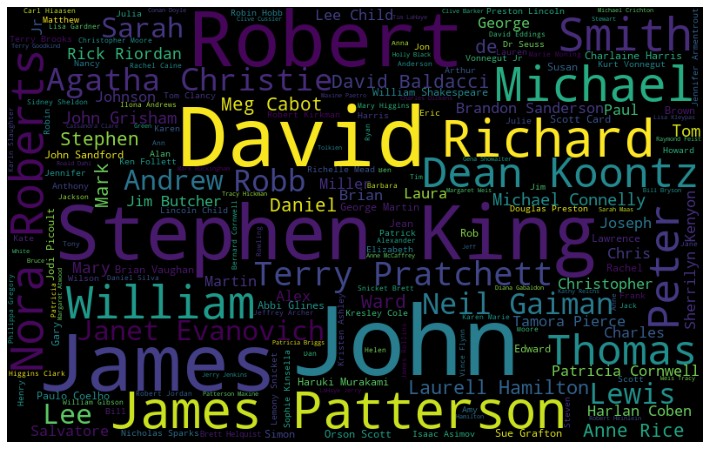

In [25]:
wordcloud(author_string)

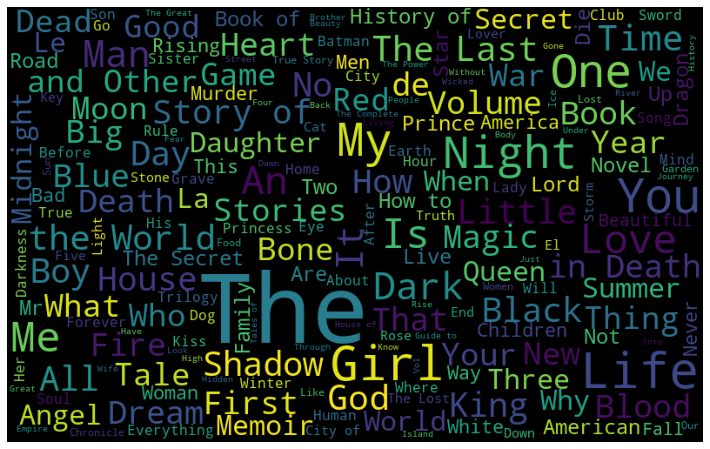

In [26]:
wordcloud(title_string)

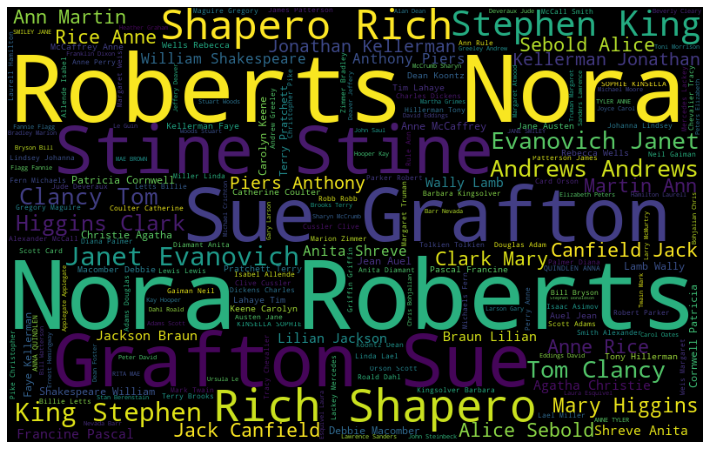

In [27]:
wordcloud(cross_author_string)

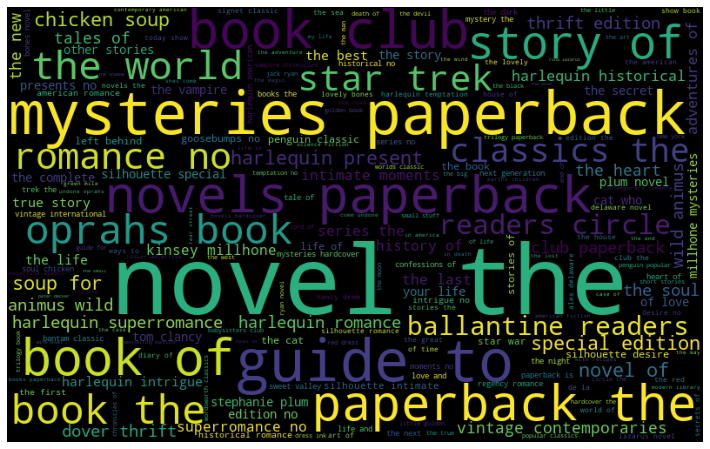

In [28]:
wordcloud(cross_title_string)

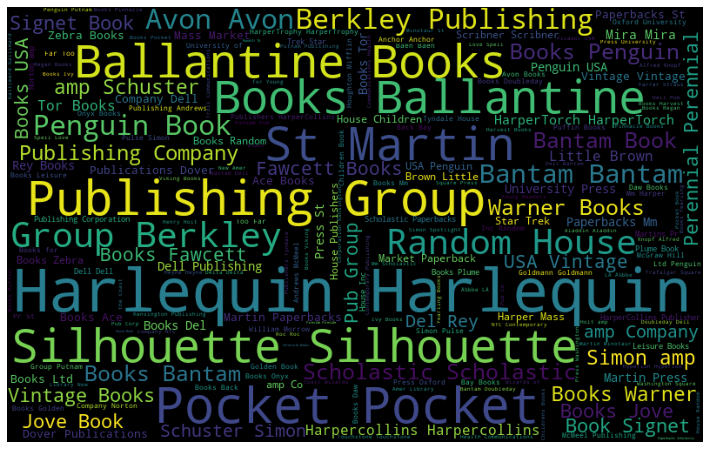

In [29]:
wordcloud(cross_publisher_string)

# 3. content based recommondation

**This method uses attributes of the content to recommend similar content. It doesn’t have a cold-start problem because it works through attributes or tags of the content, such as book title, authors or rating, so that new book can be recommended right away.**

In [30]:
content_data = books_data[['original_title','authors','average_rating']]
content_data = content_data.astype(str)

In [31]:
content_data['content'] = content_data['original_title'] + ' ' + content_data['authors'] + ' ' + content_data['average_rating']

In [32]:
content_data = content_data.reset_index()
indices = pd.Series(content_data.index, index=content_data['original_title'])

**3.1 content based recommodation author**

In [33]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(content_data['authors'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8175, 5484)

*The advantage of TF-IDF encoding is that it will weigh a term (a tag for a book in our example) according to the importance of the term within the document: The more frequently the term appears, the larger its weight will be. At the same time, it weighs the item inversely to the frequency of this term across the entire dataset: It will emphasise terms that are relatively rare occurrences in the general dataset but of importance to the specific content at hand. That means that words such as ‘is’, ‘are’, ‘by’ or ‘a’ which are likely to show up in every book content but aren’t useful for our user-recommendation, will be weighed less than words that are more unique to the content that we are recommending.*

**Compute the cosine similarity matrix**

*We are going to use a simple similarity-based method called cosine similarity*

In [34]:
cosine_sim_author = linear_kernel(tfidf_matrix, tfidf_matrix)

**author wise recommodation**

In [35]:
def get_recommendations_books(title, cosine_sim=cosine_sim_author):
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim_author[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return list(content_data['original_title'].iloc[book_indices])

In [36]:
def author_book_shows(book):
    for book in book:
        print(book)

In [37]:
books1 = get_recommendations_books('The Hobbit', cosine_sim_author)
author_book_shows(books1)

The Hobbit or There and Back Again
 The Fellowship of the Ring
The Two Towers
The Return of the King
The Lord of the Rings
The Hobbit and The Lord of the Rings
Nikola Tesla: Imagination and the Man That Invented the 20th Century
The Children of Húrin
Entwined
The 7 Habits Of Highly Effective Teens


In [38]:
books2 =get_recommendations_books('Shadow Kiss', cosine_sim_author)
author_book_shows(books2)

Shadow Kiss
Spirit Bound
Blood Promise
Last Sacrifice 
Bloodlines
The Golden Lily
The Indigo Spell
The Fiery Heart
Succubus Blues
Silver Shadows


In [39]:
books3 = get_recommendations_books('Harry Potter and the Goblet of Fire', cosine_sim_author)
author_book_shows(books3)

Harry Potter and the Order of the Phoenix
Harry Potter and the Chamber of Secrets
Harry Potter and the Goblet of Fire
Harry Potter and the Deathly Hallows
Harry Potter and the Half-Blood Prince
Harry Potter Boxed Set Books 1-4
Harry Potter and the Prisoner of Azkaban
The Casual Vacancy
The Tales of Beedle the Bard
Complete Harry Potter Boxed Set


**3.2 content based filtering on multiple matrix**

In [40]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(content_data['content'])

cosine_sim_content = cosine_similarity(count_matrix, count_matrix)

In [41]:
def get_recommendations(title, cosine_sim=cosine_sim_content):
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim_content[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return list(content_data['original_title'].iloc[book_indices])

In [42]:
def book_shows(book):
    for book in book:
        print(book)

In [43]:
books4 = get_recommendations('The Hobbit', cosine_sim_content)
book_shows(books4)

The Hobbit or There and Back Again
The Hobbit and The Lord of the Rings
No, David!
The History of the Hobbit, Part One: Mr. Baggins
The Silmarillion
The Children of Húrin
The Two Towers
Diary
Next
Us


In [44]:
books5 =get_recommendations('Shadow Kiss', cosine_sim_content)
book_shows(books5)

Spirit Bound
Silver Shadows
Frostbite
Last Sacrifice 
Bloodlines
Storm Born
Succubus On Top
Blood Promise
The Golden Lily
The Indigo Spell


In [45]:
books6 =get_recommendations('The Two Towers', cosine_sim_content)
book_shows(books6)

Towers of Midnight
The Silmarillion
The Children of Húrin
The Hobbit or There and Back Again
Reckless
 The Fellowship of the Ring
The Return of the King
The Lord of the Rings
Last Sacrifice 
Roots


In [46]:
books7 = get_recommendations('Harry Potter and the Goblet of Fire', cosine_sim_content)
book_shows(books7)

Harry Potter and the Prisoner of Azkaban
Harry Potter and the Philosopher's Stone
Harry Potter and the Order of the Phoenix
Harry Potter and the Chamber of Secrets
Harry Potter and the Deathly Hallows
Harry Potter and the Half-Blood Prince
Harry Potter Boxed Set Books 1-4
Harry Potter Collection (Harry Potter, #1-6)
Complete Harry Potter Boxed Set
Harry, A History: The True Story of a Boy Wizard, His Fans, and Life Inside the Harry Potter Phenomenon


# 4. colloaborative Recommendation

**In collaborative-filtering items are recommended, for example books, based on how similar your user profile is to other users’, finds the users that are most similar to you and then recommends items that they have shown a preference for. This method suffers from the so-called cold-start problem: If there is a new book, no-one else would’ve yet liked or watched it, so you’re not going to have this in your list of recommended books, even if you’d love it.**

In [47]:
merge_data = merge_data[:40000]

**pivot table**

In [48]:
book_rating = pd.pivot_table(merge_data, index='user_id', values='rating', columns='book_title', fill_value=0)
book_rating

book_title,,the year china discovered america,a beginners guide,a space odyssey a novel by arthur c clarke,allamerican favorites,an action plan to protect yourself your family your assets and your community on january,backup amp recovery,barbary lane a tales of the city omnibus,beers and a chinese meal,black chicks review flicks a film and video guide with flava,...,zone food blocks the quick and easy mixandmatch counter for staying in the zone,zone perfect meals in minutes fast and simple healthy recipes from the bestselling authorof the zone and mastering the zone,zoo animals a smithsonian guide smithsonian guides,zoology coloring book,zoyas story an afghan womans struggle for freedom,zucchini out west,zuleika dobson penguin modern classics,zulu dawn,â¡dã­melo tu,â¡trato hecho spanish for real life edition
user_id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**find correlation b/w books**

In [49]:
book_corr = np.corrcoef(book_rating.T)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



In [50]:
book_corr.shape

(12020, 12020)

In [51]:
book_list=  list(book_rating)
book_titles =[] 
for i in range(len(book_list)):
    book_titles.append(book_list[i])

**Define Recommendation function**

In [52]:
def get_recommendation_collabarative(books_list):
    similar_books = np.zeros(book_corr.shape[0])
    
    for book in books_list:    
        book_index = book_titles.index(book)
        similar_books += book_corr[book_index] 
    book_preferences = []
    for i in range(len(book_titles)):
        book_preferences.append((book_titles[i],similar_books[i]))
        
    return sorted(book_preferences, key= lambda x: x[1], reverse=True)

**make a book list**

In [53]:
list_of_books = ['one hundred years of solitude',
                 'stardust',
                 'mogs christmas',
                 'dragonmede',
                 'twopence to cross the mersey',
                 'the candywine development']

In [54]:
books8 = get_recommendation_collabarative(list_of_books)

**top similar books collabarative**

In [55]:
i=0
n =0
while n < 9:
    similar_books_to_read= books8[i][0]
    i += 1
    if similar_books_to_read in list_of_books:
        continue
    else:
        print(similar_books_to_read)
        n += 1


  the year china discovered america
 a beginners guide
 a space odyssey  a novel by arthur c clarke
 allamerican favorites
 an action plan to protect yourself your family your assets  and your community on january  
 backup amp recovery
 barbary lane  a tales of the city omnibus
 beers and a chinese meal


# If you found this kernel helpful, please upvote it.